In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib notebook


# feature engineering
import featuretools as ft

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os

## 1. Load data

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [134]:
data = pd.read_csv('online_retail_data.csv', encoding = "ISO-8859-1")

In [135]:
len(data)

541909

In [240]:
# deleting all rows without a CustomerID
len(data[data['CustomerID'].isnull()])

135080

In [241]:
data = data[data['CustomerID'].isnull() == False]

In [242]:
len(data)

406829

In [243]:
# sample the data (25% of data)
# data = data[0:int(len(data) / 4)]

In [245]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,Value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


In [246]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [247]:
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')

In [248]:
data['Value'] = data['Quantity'] * data['UnitPrice']
data['Value'].mean()

20.401853884564613

## 2. EDA

In [249]:
# 38 countries
len(data['Country'].unique())

37

In [250]:
# 4224 unique descriptions
len(data['Description'].unique())

3896

In [251]:
# 4070 unique stock codes
len(data['StockCode'].unique())

3684

In [252]:
# ~ 540k rows of data
len(data)

406829

In [253]:
# 123 invoices per customer
int(len(data)*1.0 / len(data['CustomerID'].unique())*1.0)

93

In [254]:
# 4373 unique customers 
len(data['CustomerID'].unique())

4372

In [3]:
# first invoice data
data['InvoiceDate'].min(), ' -> ', data['InvoiceDate'].max()

NameError: name 'data' is not defined

In [256]:
# last invoice date


Timestamp('2011-12-09 12:50:00')

In [257]:
# 312 rows of data for the first customer by index
len(data[data['CustomerID'] == data['CustomerID'][0]])

312

In [258]:
# 35 invoices for the first customer by index
len(data[data['CustomerID'] == data['CustomerID'][0]]['InvoiceNo'].unique())

35

In [427]:
# 2% of orders with a negative quantity
len(data[data['Quantity'] < 0])*1.0 /  len(data[data['Quantity'] > 0])*1.0

0.02237864516842412

## 3. Building an EntitySet

In [259]:
es = ft.EntitySet("online_retail")

In [260]:
orders = data[['InvoiceNo', 'CustomerID', 'InvoiceDate']]
orders.head()

,InvoiceNo,CustomerID,InvoiceDate
0,536365,17850.0,2010-12-01 08:26:00
1,536365,17850.0,2010-12-01 08:26:00
2,536365,17850.0,2010-12-01 08:26:00
3,536365,17850.0,2010-12-01 08:26:00
4,536365,17850.0,2010-12-01 08:26:00


In [261]:
len(orders)

406829

In [262]:
orders = orders.groupby('InvoiceNo').mean().reset_index()
orders.head()

,InvoiceNo,CustomerID
0,536365,17850.0
1,536366,17850.0
2,536367,13047.0
3,536368,13047.0
4,536369,13047.0


In [263]:
len(orders)

22190

In [264]:
# InvoiceNo | CustomerID | InvoiceDate
invoice_dates = data[['InvoiceNo', 'InvoiceDate']].groupby('InvoiceNo').min().reset_index()
orders = pd.merge(orders, invoice_dates, on='InvoiceNo', how='left')

In [265]:
orders.head()

,InvoiceNo,CustomerID,InvoiceDate
0,536365,17850.0,2010-12-01 08:26:00
1,536366,17850.0,2010-12-01 08:28:00
2,536367,13047.0,2010-12-01 08:34:00
3,536368,13047.0,2010-12-01 08:34:00
4,536369,13047.0,2010-12-01 08:35:00


In [266]:
len(orders)

22190

In [267]:
# orders = orders[['InvoiceDate', 'InvoiceDate']].groupby('InvoiceDate').min()
# orders.head()
# orders

In [268]:
es.entity_from_dataframe(entity_id='orders',
                        dataframe=orders,
                        index='InvoiceNo',
                        time_index='InvoiceDate')

Entityset: online_retail
  Entities:
    orders (shape = [22190, 3])
  Relationships:
    No relationships

In [271]:
order_products = data[['InvoiceNo', 'Description', 'InvoiceDate', 'Country', 'UnitPrice', 'Quantity', 'Value']]
order_products.head()

,InvoiceNo,Description,InvoiceDate,Country,UnitPrice,Quantity,Value
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom,2.55,6,15.30
1,536365,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom,3.39,6,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom,2.75,8,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom,3.39,6,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom,3.39,6,20.34


In [272]:
es.entity_from_dataframe(entity_id='order_products',
                        dataframe=order_products,
                        index='order_product_id',
                        time_index='InvoiceDate')

2018-01-07 15:36:54,433 featuretools.entityset - WARNING    index order_product_id not found in dataframe, creating new integer column


Entityset: online_retail
  Entities:
    order_products (shape = [406829, 8])
    orders (shape = [22190, 3])
  Relationships:
    No relationships

In [273]:
es.add_relationship(ft.Relationship(es['orders']['InvoiceNo'], es['order_products']['InvoiceNo']))

Entityset: online_retail
  Entities:
    order_products (shape = [406829, 8])
    orders (shape = [22190, 3])
  Relationships:
    order_products.InvoiceNo -> orders.InvoiceNo

In [274]:
es.normalize_entity(base_entity_id='orders', new_entity_id='customers', index='CustomerID')

Entityset: online_retail
  Entities:
    order_products (shape = [406829, 8])
    customers (shape = [4372, 2])
    orders (shape = [22190, 3])
  Relationships:
    order_products.InvoiceNo -> orders.InvoiceNo
    orders.CustomerID -> customers.CustomerID

In [275]:
len(data['CustomerID'].unique())

4372

## 4. Building labels

In [276]:
# predicting whether a customer will be a big spender in the last month of available data

In [277]:
# diff in days
data['InvoiceDate'].max() - data['InvoiceDate'].min()

Timedelta('373 days 04:24:00')

In [278]:
# 1 year of training data - 12 January 2010 to 12 January 2011
data['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [279]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

<IPython.core.display.Javascript object>


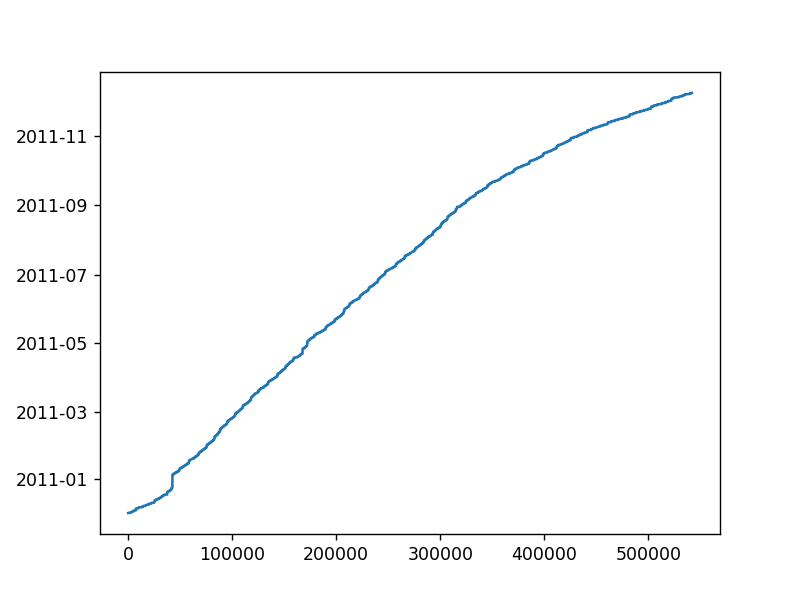

In [360]:
data['InvoiceDate'].plot();

In [172]:
pd.Timestamp('January 1, 2011')

Timestamp('2011-01-01 00:00:00')

In [281]:
# 1 Dec 2010 + 60 days = cutoff value
# training -> data from Dec 1 2010 -> cutoff time
# prediction -> cutoff time + 4 weeks
cutoff_time = pd.Timestamp('January 30, 2011')
prediction_window = ft.Timedelta("4 weeks")
training_window = ft.Timedelta("60 days")

prediction_window_end = cutoff_time + prediction_window
t_start = cutoff_time - training_window

In [282]:
prediction_window_end

Timestamp('2011-02-27 00:00:00')

In [283]:
t_start

Timestamp('2010-12-01 00:00:00')

In [284]:
orders = es['orders'].df
ops = es['order_products'].df

In [285]:
ops.head()

,order_product_id,InvoiceNo,Description,InvoiceDate,Country,UnitPrice,Quantity,Value
order_product_id,,,,,,,,
0,0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom,2.55,6,15.30
1,1,536365,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom,3.39,6,20.34
2,2,536365,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom,2.75,8,22.00
3,3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom,3.39,6,20.34
4,4,536365,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom,3.39,6,20.34


In [286]:
orders.head()

,InvoiceNo,CustomerID,InvoiceDate
InvoiceNo,,,
536365,536365,17850.0,2010-12-01 08:26:00
536366,536366,17850.0,2010-12-01 08:28:00
536367,536367,13047.0,2010-12-01 08:34:00
536368,536368,13047.0,2010-12-01 08:34:00
536369,536369,13047.0,2010-12-01 08:35:00


In [287]:
training_data = ops[(ops['InvoiceDate'] <= cutoff_time) & (ops['InvoiceDate'] > t_start)]
prediction_data = ops[(ops['InvoiceDate'] > cutoff_time) & (ops['InvoiceDate'] < prediction_window_end)]

In [289]:
users_in_training = training_data.merge(orders)['CustomerID'].unique()

In [290]:
valid_pred_data = prediction_data.merge(orders)
valid_pred_data = valid_pred_data[valid_pred_data['CustomerID'].isin(users_in_training)]

In [291]:
valid_pred_data.head()

,order_product_id,InvoiceNo,Description,InvoiceDate,Country,UnitPrice,Quantity,Value,CustomerID
0,47004,542595,ASSORTED EASTER DECORATIONS BELLS,2011-01-30 10:19:00,United Kingdom,1.25,6,7.50,14040.0
1,47005,542595,DOORMAT HEARTS,2011-01-30 10:19:00,United Kingdom,7.95,1,7.95,14040.0
2,47006,542595,DOORMAT RED RETROSPOT,2011-01-30 10:19:00,United Kingdom,7.95,2,15.90,14040.0
3,47007,542595,DOORMAT WELCOME PUPPIES,2011-01-30 10:19:00,United Kingdom,7.95,1,7.95,14040.0
4,47008,542595,DOORMAT UNION JACK GUNS AND ROSES,2011-01-30 10:19:00,United Kingdom,7.95,1,7.95,14040.0


In [293]:
# get how much a customer spent each month on average- whether they were big spenders in the past
# predict whether they will be a big spender in the next month

In [548]:
label = 'high_value_customer'

### High value customer?

In [549]:
# 2 months of data per each customer, get a 80 percetile of customers based on spending (high spenders)

In [550]:
high_value = (data.groupby('CustomerID').sum()['Value'] / 2).quantile(0.80)

In [551]:
if label == 'high_value_customer':
    label_times = pd.DataFrame((valid_pred_data.groupby('CustomerID').sum()['Value'] / 2) > high_value).reset_index()
    label_times['cutoff_time'] = cutoff_time
    label_times.columns = ['CustomerID', 'label', 'time']
    label_times.head()

In [552]:
len(label_times['CustomerID'].unique())

429

### Repurchase product?

In [553]:
data['Description'].value_counts()[0:20]

WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
LUNCH BAG RED RETROSPOT               1358
SET OF 3 CAKE TINS PANTRY DESIGN      1232
POSTAGE                               1196
LUNCH BAG  BLACK SKULL.               1126
PACK OF 72 RETROSPOT CAKE CASES       1080
PAPER CHAIN KIT 50'S CHRISTMAS        1029
SPOTTY BUNTING                        1029
LUNCH BAG SPACEBOY DESIGN             1021
LUNCH BAG CARS BLUE                   1012
NATURAL SLATE HEART CHALKBOARD         997
HEART OF WICKER SMALL                  996
LUNCH BAG PINK POLKADOT                977
JAM MAKING SET WITH JARS               974
REX CASH+CARRY JUMBO SHOPPER           955
LUNCH BAG SUKI DESIGN                  950
Name: Description, dtype: int64

In [554]:
len(data[data['Description'] == 'LUNCH BAG PINK POLKADOT']['CustomerID'].unique())

445

In [555]:
# did the customer buy the product?
customer_bought_product = valid_pred_data[valid_pred_data['Description'] ==  'LUNCH BAG PINK POLKADOT']['CustomerID'].tolist()
customer_bought_product[0:5]

[13148.0, 12720.0, 17068.0, 14744.0, 12682.0]

In [556]:
# bought a product?
if label == 'repurchase_product':
    customer_bought_product = valid_pred_data[valid_pred_data['Description'] ==  'LUNCH BAG PINK POLKADOT']['CustomerID'].tolist()
    customer_bought_product_binary = valid_pred_data['CustomerID'].isin(customer_bought_product)
    label_times = pd.DataFrame(valid_pred_data['CustomerID'].unique())
    label_times['label'] = customer_bought_product_binary
    label_times['cutoff_time'] = cutoff_time
    label_times.columns = ['CustomerID', 'label', 'time']

In [557]:
label_times.head()

,CustomerID,label,time
0,12359.0,False,2011-01-30
1,12388.0,False,2011-01-30
2,12395.0,False,2011-01-30
3,12415.0,True,2011-01-30
4,12423.0,False,2011-01-30


In [558]:
# class balance
label_times['label'].value_counts()

False    406
True      23
Name: label, dtype: int64

## 5. Automated feature engineering

In [559]:
feature_matrix, features = ft.dfs(target_entity='customers',
                                 cutoff_time=label_times,
                                 training_window=ft.Timedelta('60 days'),
                                 entityset=es,
                                 verbose=True)

Building features: 190it [00:00, 2743.21it/s]
Progress:   0%|          | 0/1 [00:00<?, ?cutoff time/s]2018-01-07 17:06:33,069 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity customers
2018-01-07 17:06:33,291 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity orders
2018-01-07 17:06:33,668 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity order_products
Progress: 100%|██████████| 1/1 [00:34<00:00, 34.80s/cutoff time]


In [560]:
# encode categorical features
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                 features)

print('Number of features %s' % len(features_encoded))
fm_encoded.head()

Number of features 230


,SUM(order_products.UnitPrice),SKEW(order_products.UnitPrice),SUM(order_products.Value),MAX(order_products.Quantity),MIN(order_products.Quantity),SUM(order_products.Quantity),STD(order_products.Value),MAX(order_products.Value),SKEW(order_products.Value),MAX(order_products.UnitPrice),...,MIN(orders.STD(order_products.Value)),SUM(orders.MAX(order_products.Value)),MAX(orders.STD(order_products.UnitPrice)),NUM_UNIQUE(orders.MODE(order_products.Description)),MEAN(orders.STD(order_products.UnitPrice)),MIN(orders.SUM(order_products.Quantity)),MIN(orders.COUNT(order_products)),SKEW(orders.STD(order_products.UnitPrice)),SUM(orders.SKEW(order_products.UnitPrice)),STD(orders.NUM_UNIQUE(order_products.Country))
CustomerID,,,,,,,,,,,,,,,,,,,,,
12359.0,292.01,2.244135,547.50,20,1,144,39.468452,125.0,1.504796,125.00,...,39.468452,125.00,40.457023,1,40.457023,144,16,0.000000,2.244135,0
12388.0,52.15,0.292934,431.30,24,3,204,11.552341,47.4,0.725324,5.45,...,11.552341,47.40,1.634327,1,1.634327,204,19,0.000000,0.292934,0
12395.0,108.04,1.966699,676.97,120,-1,752,15.517956,54.0,0.701825,18.00,...,0.000000,101.45,5.159708,3,3.388093,-1,1,-0.704885,3.928814,0
12415.0,86.93,2.145328,7092.98,576,6,4758,158.262888,1020.0,3.922171,6.75,...,0.000000,1101.60,1.372000,2,0.686000,96,1,0.000000,2.120915,0
12423.0,42.19,2.423421,237.93,24,2,188,9.236188,45.0,2.349945,15.00,...,9.236188,45.00,3.715206,1,3.715206,188,16,0.000000,2.423421,0


In [561]:
pd.Series(fm_encoded.columns)

0                          SUM(order_products.UnitPrice)
1                         SKEW(order_products.UnitPrice)
2                              SUM(order_products.Value)
3                           MAX(order_products.Quantity)
4                           MIN(order_products.Quantity)
5                           SUM(order_products.Quantity)
6                              STD(order_products.Value)
7                              MAX(order_products.Value)
8                             SKEW(order_products.Value)
9                          MAX(order_products.UnitPrice)
10                    NUM_UNIQUE(order_products.Country)
11     MODE(order_products.Description) = ASSORTED CO...
12     MODE(order_products.Description) = ALARM CLOCK...
13     MODE(order_products.Description) = WHITE HANGI...
14     MODE(order_products.Description) = REGENCY CAK...
15     MODE(order_products.Description) =  SET 2 TEA ...
16            MODE(order_products.Description) = POSTAGE
17     MODE(order_products.Desc

## 6. Machine Learning

In [562]:
X.head()

,SUM(order_products.UnitPrice),SKEW(order_products.UnitPrice),SUM(order_products.Value),MAX(order_products.Quantity),MIN(order_products.Quantity),SUM(order_products.Quantity),STD(order_products.Value),MAX(order_products.Value),SKEW(order_products.Value),MAX(order_products.UnitPrice),...,MIN(orders.STD(order_products.Value)),SUM(orders.MAX(order_products.Value)),MAX(orders.STD(order_products.UnitPrice)),NUM_UNIQUE(orders.MODE(order_products.Description)),MEAN(orders.STD(order_products.UnitPrice)),MIN(orders.SUM(order_products.Quantity)),MIN(orders.COUNT(order_products)),SKEW(orders.STD(order_products.UnitPrice)),SUM(orders.SKEW(order_products.UnitPrice)),STD(orders.NUM_UNIQUE(order_products.Country))
0,292.01,2.244135,547.50,20,1,144,39.468452,125.0,1.504796,125.00,...,39.468452,125.00,40.457023,1,40.457023,144,16,0.000000,2.244135,0
1,52.15,0.292934,431.30,24,3,204,11.552341,47.4,0.725324,5.45,...,11.552341,47.40,1.634327,1,1.634327,204,19,0.000000,0.292934,0
2,108.04,1.966699,676.97,120,-1,752,15.517956,54.0,0.701825,18.00,...,0.000000,101.45,5.159708,3,3.388093,-1,1,-0.704885,3.928814,0
3,86.93,2.145328,7092.98,576,6,4758,158.262888,1020.0,3.922171,6.75,...,0.000000,1101.60,1.372000,2,0.686000,96,1,0.000000,2.120915,0
4,42.19,2.423421,237.93,24,2,188,9.236188,45.0,2.349945,15.00,...,9.236188,45.00,3.715206,1,3.715206,188,16,0.000000,2.423421,0


In [563]:
# with the generated features we use the feature matrix
# merge all features into one
X = fm_encoded.reset_index().merge(label_times)
X.drop(['CustomerID', 'time'], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop('label').astype('int')

In [564]:
y.value_counts()

0    406
1     23
Name: label, dtype: int64

In [565]:
# build first a random forest classifier, 3-fold cross validation
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, scoring='roc_auc', verbose=True)
"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s finished


'AUC 0.89 +/- 0.05'

In [566]:
scores

array([ 0.86219512,  0.97530864,  0.85555556,  0.82407407,  0.91203704])

In [567]:
# F1 score -> harmonic mean of precision and recall
# precision -> how certain when we predict positive
# recall -> how certain we are aoubt predicting 

In [ ]:
from sklearn.metrics import f1_score
scores = f1_score(y_true, y_pred)
"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

In [202]:
# based on the std determine whether present variance
# solutions: more data or less features

In [541]:
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [542]:
# feature importance calculation
importances = clf.feature_importances_
# number of top features to keep
n = 20

zipped = sorted(zip(features, importances), key=lambda x: - x[1])

for i, f in enumerate(zipped[:n]):
    print("%d: Feature: %s, %.3f" % (i+1, f[0].get_name(), f[1]))

top_features = [f[0] for f in zipped[:n]]
top_features

1: Feature: SKEW(orders.STD(order_products.UnitPrice)), 0.013
2: Feature: MAX(orders.MEAN(order_products.UnitPrice)), 0.013
3: Feature: STD(orders.MEAN(order_products.UnitPrice)), 0.012
4: Feature: STD(orders.SUM(order_products.UnitPrice)), 0.012
5: Feature: MIN(orders.COUNT(order_products)), 0.012
6: Feature: STD(orders.MAX(order_products.UnitPrice)), 0.011
7: Feature: NUM_UNIQUE(orders.MONTH(InvoiceDate)), 0.011
8: Feature: SKEW(order_products.UnitPrice), 0.011
9: Feature: MEAN(orders.MAX(order_products.Value)), 0.011
10: Feature: MIN(order_products.UnitPrice), 0.010
11: Feature: MIN(orders.STD(order_products.Quantity)), 0.010
12: Feature: STD(orders.SUM(order_products.Quantity)), 0.010
13: Feature: MODE(orders.MODE(order_products.Description)), 0.010
14: Feature: MAX(orders.MIN(order_products.UnitPrice)), 0.010
15: Feature: SUM(order_products.Quantity), 0.010
16: Feature: SUM(orders.MEAN(order_products.UnitPrice)), 0.010
17: Feature: MODE(orders.MODE(order_products.Country)), 0.009


[<Feature: SKEW(orders.STD(order_products.UnitPrice))>,
 <Feature: MAX(orders.MEAN(order_products.UnitPrice))>,
 <Feature: STD(orders.MEAN(order_products.UnitPrice))>,
 <Feature: STD(orders.SUM(order_products.UnitPrice))>,
 <Feature: MIN(orders.COUNT(order_products))>,
 <Feature: STD(orders.MAX(order_products.UnitPrice))>,
 <Feature: NUM_UNIQUE(orders.MONTH(InvoiceDate))>,
 <Feature: SKEW(order_products.UnitPrice)>,
 <Feature: MEAN(orders.MAX(order_products.Value))>,
 <Feature: MIN(order_products.UnitPrice)>,
 <Feature: MIN(orders.STD(order_products.Quantity))>,
 <Feature: STD(orders.SUM(order_products.Quantity))>,
 <Feature: MODE(orders.MODE(order_products.Description))>,
 <Feature: MAX(orders.MIN(order_products.UnitPrice))>,
 <Feature: SUM(order_products.Quantity)>,
 <Feature: SUM(orders.MEAN(order_products.UnitPrice))>,
 <Feature: MODE(orders.MODE(order_products.Country))>,
 <Feature: SKEW(order_products.Value)>,
 <Feature: SKEW(orders.NUM_UNIQUE(order_products.Description))>,
 <Fea

In [569]:
top_features[0]

<Feature: SKEW(orders.STD(order_products.UnitPrice))>

In [209]:
ft.save_features(top_features, 'top features')

In [207]:
# feature engineering -> aggregations and stacking of aggregations across relationships in the dataset

In [208]:
# rerun the classifier with one the top features to reduce the variance

In [ ]:
top_features = ft.load_features('top_features', es)

In [ ]:
label_times, es = 